 Избор на податочно множество за Алцхајмерова болест и негова анализа преку соодветна методологија.

# Импорти

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [2]:
%pip install xgboost


вчитување на податоците

In [3]:
df = pd.read_csv('/content/alzheimers_disease_data.csv')
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751.0,73.0,Male,Caucasian,Bachelor's,22.927749,NaN,13.297218,6.327112,1.347214,...,No,No,1.725883,No,No,No,Yes,No,No,XXXConfid
1,4752.0,89.0,Male,Caucasian,No,26.827681,NaN,4.542524,7.619885,0.518767,...,No,No,2.592424,No,No,No,No,NaN,No,XXXConfid
2,4753.0,73.0,Male,Other,High School,17.795882,No,19.555085,7.844988,1.826335,...,No,No,7.119548,No,Yes,No,Yes,No,No,XXXConfid
3,4754.0,74.0,Female,Caucasian,High School,33.800817,Yes,12.209266,8.428001,7.435604,...,No,Yes,6.481226,No,No,No,No,No,No,XXXConfid
4,4755.0,89.0,Male,Caucasian,No,NaN,No,18.454356,6.310461,NaN,...,No,No,0.014691,No,No,Yes,Yes,No,No,XXXConfid


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2055 non-null   float64
 1   Age                        2042 non-null   float64
 2   Gender                     2024 non-null   object 
 3   Ethnicity                  2044 non-null   object 
 4   EducationLevel             2041 non-null   object 
 5   BMI                        2017 non-null   float64
 6   Smoking                    2050 non-null   object 
 7   AlcoholConsumption         2032 non-null   float64
 8   PhysicalActivity           2053 non-null   float64
 9   DietQuality                2031 non-null   float64
 10  SleepQuality               2045 non-null   float64
 11  FamilyHistoryAlzheimers    2040 non-null   object 
 12  CardiovascularDisease      2031 non-null   object 
 13  Diabetes                   2034 non-null   objec

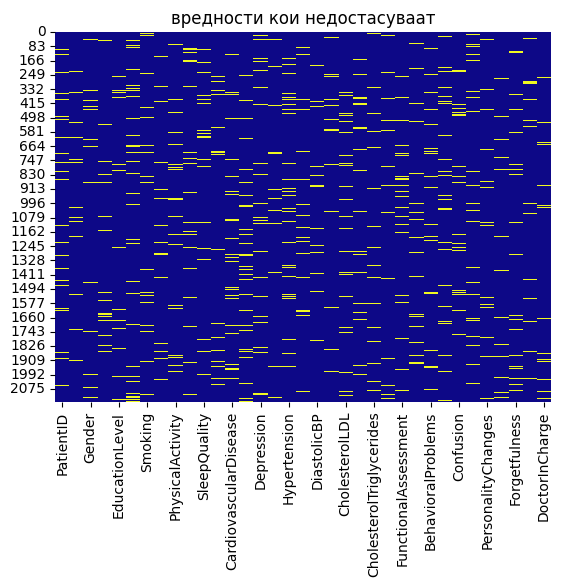

                       column  percent missing
0                   PatientID         4.374128
1                         Age         4.979060
2                      Gender         5.816659
3                   Ethnicity         4.885993
4              EducationLevel         5.025593
5                         BMI         6.142392
6                     Smoking         4.606794
7          AlcoholConsumption         5.444393
8            PhysicalActivity         4.467194
9                 DietQuality         5.490926
10               SleepQuality         4.839460
11    FamilyHistoryAlzheimers         5.072127
12      CardiovascularDisease         5.490926
13                   Diabetes         5.351326
14                 Depression         4.606794
15                 HeadInjury         4.792927
16               Hypertension         5.630526
17                 SystolicBP         4.746394
18                DiastolicBP         4.141461
19           CholesterolTotal         5.490926
20           

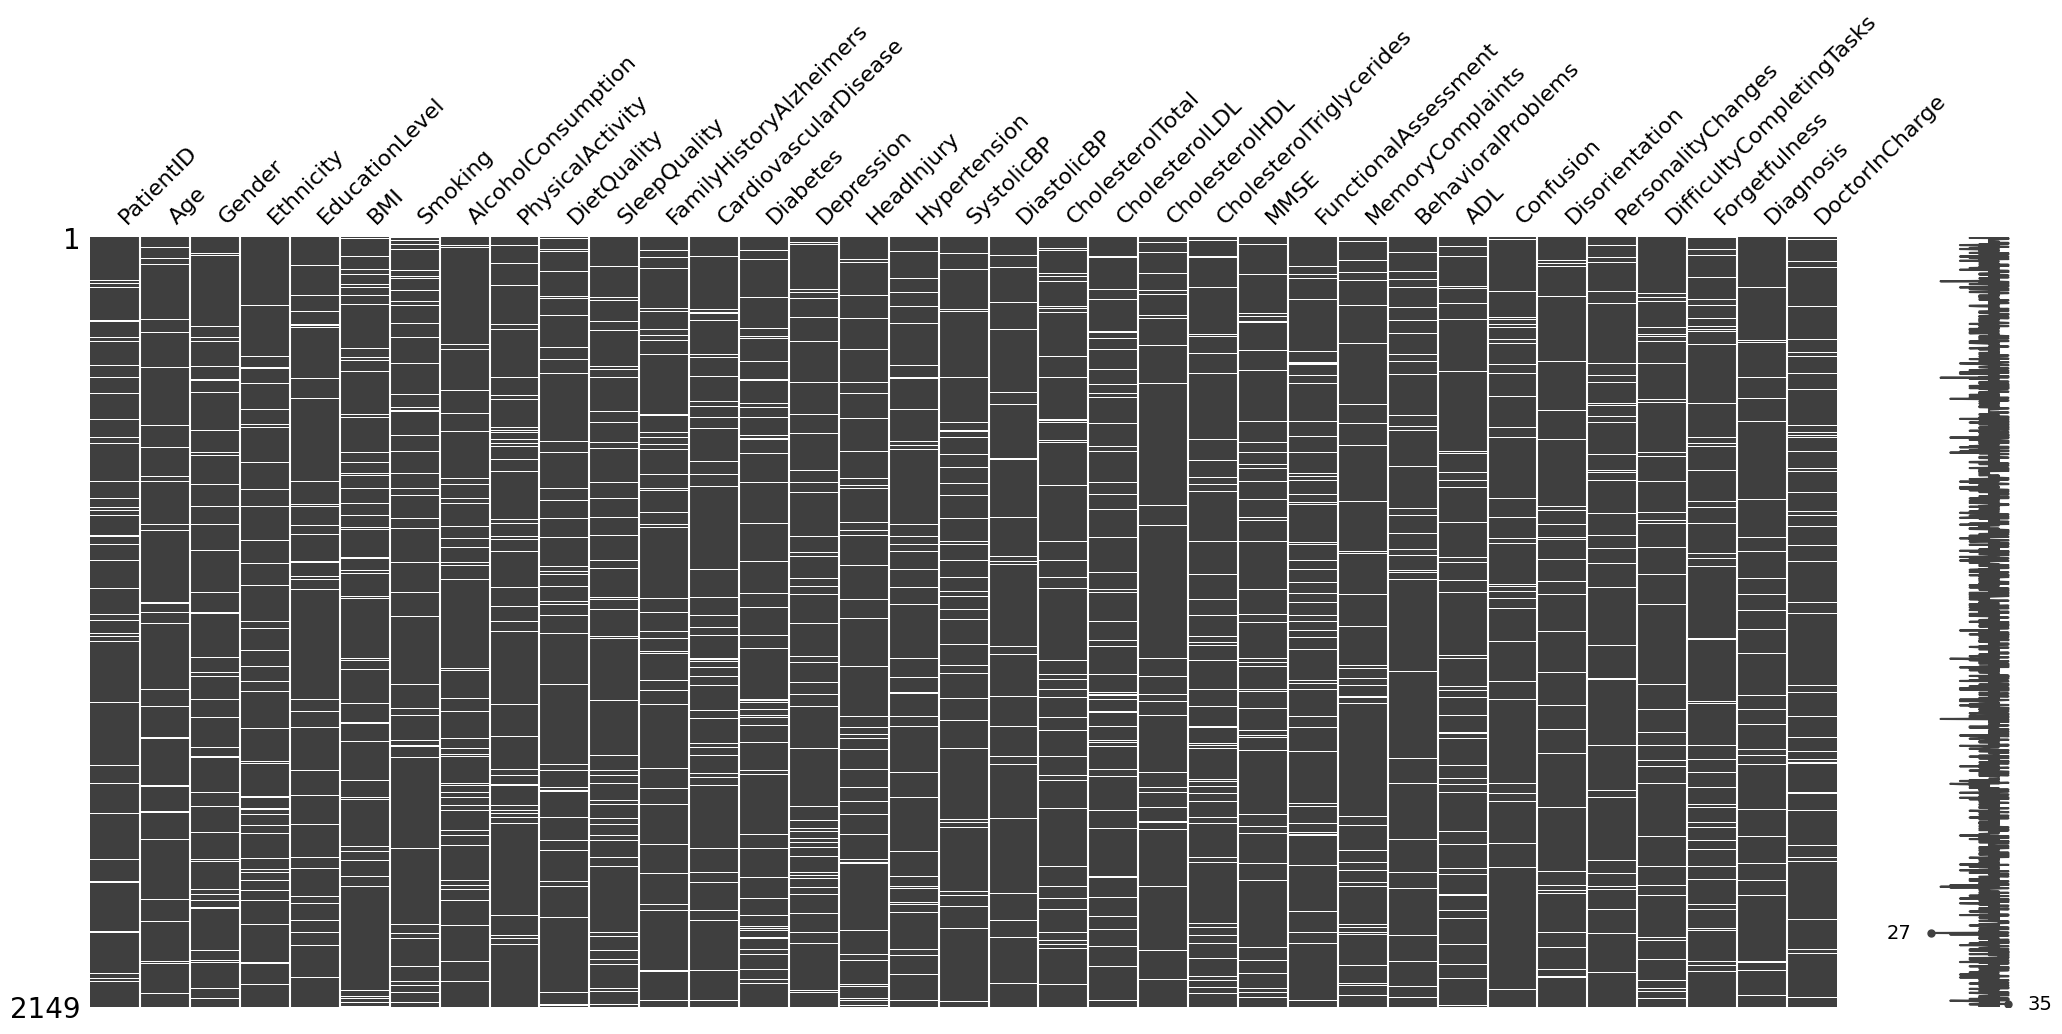

In [4]:
df.info()
sns.heatmap(df.isnull(), cbar=False, cmap='plasma')
plt.title("вредности кои недостасуваат")
plt.show()
missing_percent = df.isnull().sum() / len(df) * 100
missing_percent = missing_percent.reset_index().rename(columns={"index": "column", 0: "percent missing"})
print(missing_percent)
msno.matrix(df)
plt.show()


предпроцесирање на податоците


In [5]:
df = df.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols += df.select_dtypes(include='bool').columns.tolist()

le = LabelEncoder()
for col in cat_cols:

    df[col] = df[col].fillna(np.nan)
    mask = df[col].notna()
    df.loc[mask, col] = le.fit_transform(df.loc[mask, col].astype(str))

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
for col in cat_cols:
    df_imputed[col] = df_imputed[col].round().astype(int)


In [6]:
df.head()


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73.0,1,2,0,22.927749,NaN,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89.0,1,2,3,26.827681,NaN,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,NaN,0
2,73.0,1,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,NaN,0,0,7.119548,0,1,0,1,0,0
3,74.0,0,2,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89.0,1,2,3,NaN,0,18.454356,6.310461,NaN,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [7]:
df_imputed.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73.0,1,2,0,22.927749,1,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89.0,1,2,3,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,0,0
2,73.0,1,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,7.821457,0,0,7.119548,0,1,0,1,0,0
3,74.0,0,2,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89.0,1,2,3,27.607810,0,18.454356,6.310461,5.381606,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


Анализа на податоците и визуализација

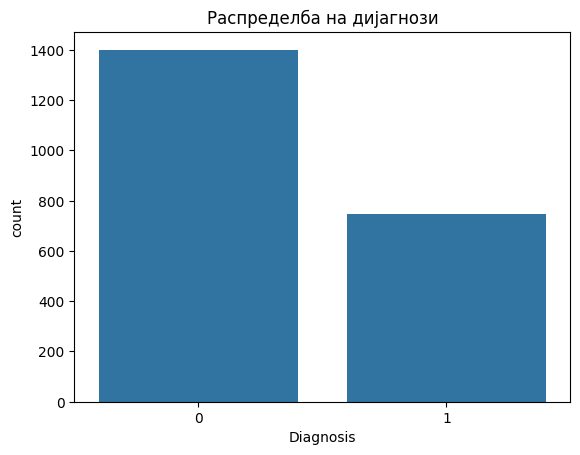

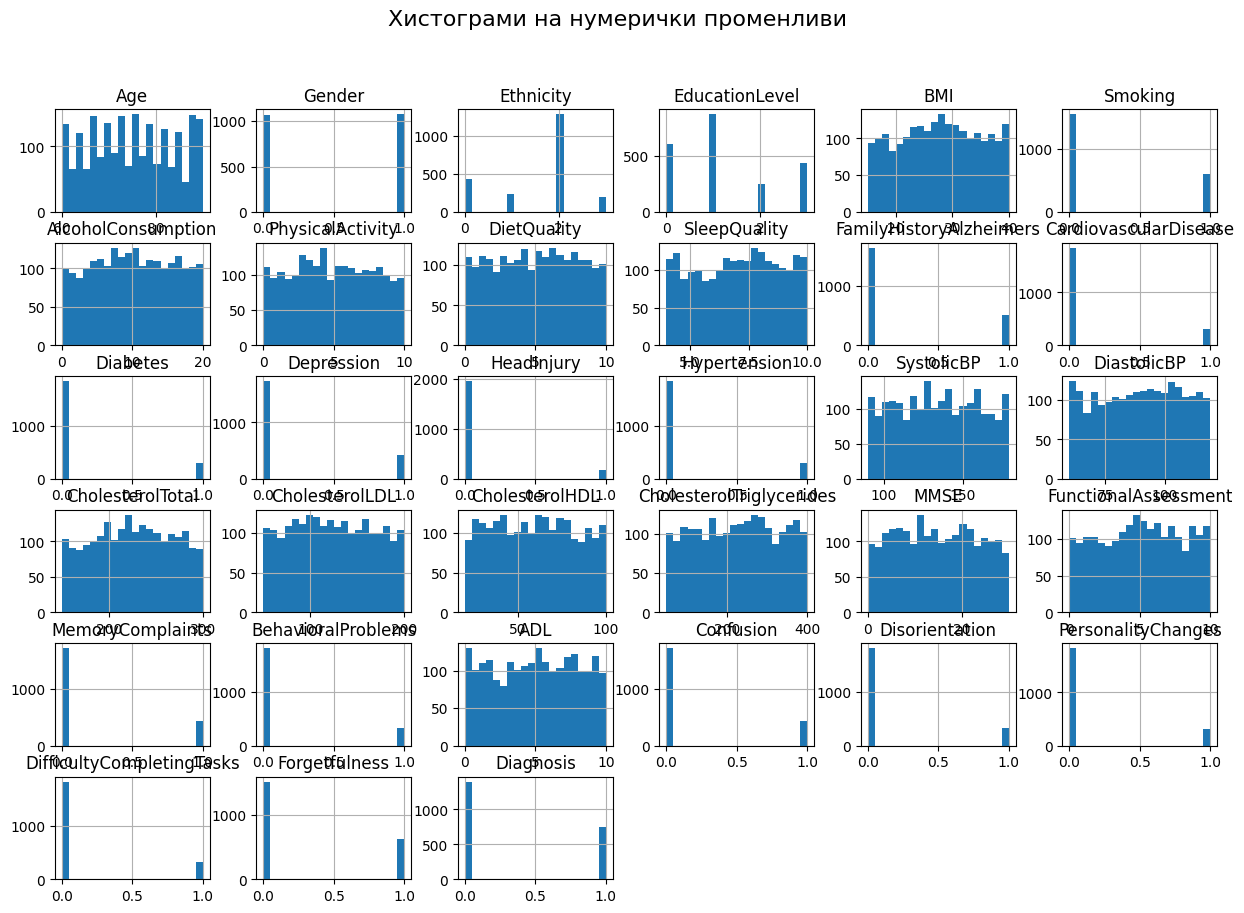

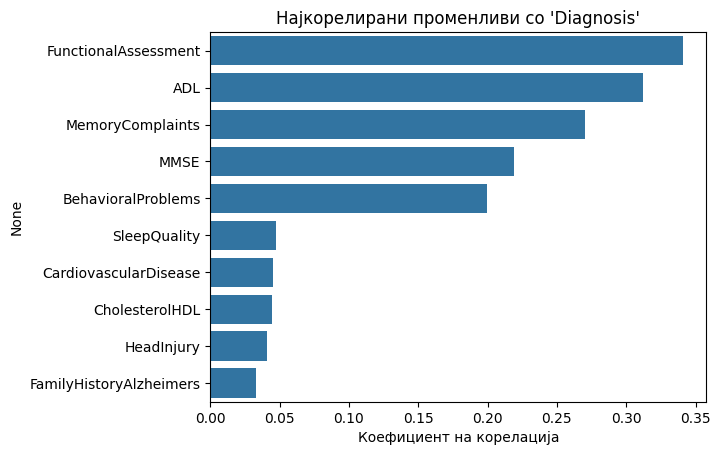

In [8]:

sns.countplot(data=df_imputed, x='Diagnosis')
plt.title("Распределба на дијагнози")
plt.show()

df_imputed.select_dtypes(include='number').hist(bins=20, figsize=(15, 10))
plt.suptitle("Хистограми на нумерички променливи", fontsize=16)
plt.show()

corr = df_imputed.corr(numeric_only=True)
top_corr_features = corr['Diagnosis'].abs().sort_values(ascending=False)[1:11]
sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
plt.title("Најкорелирани променливи со 'Diagnosis'")
plt.xlabel("Коефициент на корелација")
plt.show()


делење на податочно множество и скалирање




In [9]:
X = df_imputed.drop("Diagnosis", axis=1)
y = df_imputed["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Модели

In [10]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv_strategy,
                           scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Најдобри параметри:", grid_search.best_params_)
print("Најдобра точност (accuracy):", grid_search.best_score_)


Најдобри параметри: {'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}
Најдобра точност (accuracy): 0.7481151264492508


Accuracy: 0.7023255813953488

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       278
           1       0.68      0.30      0.41       152

    accuracy                           0.70       430
   macro avg       0.69      0.61      0.61       430
weighted avg       0.70      0.70      0.66       430


Confusion Matrix:


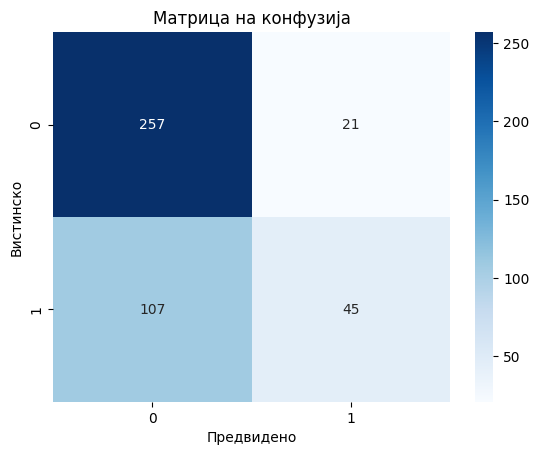

In [11]:
best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица на конфузија")
plt.xlabel("Предвидено")
plt.ylabel("Вистинско")
plt.show()


In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Accuracy: 0.8046511627906977
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       278
           1       0.76      0.66      0.70       152

    accuracy                           0.80       430
   macro avg       0.79      0.77      0.78       430
weighted avg       0.80      0.80      0.80       430



In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.8023255813953488
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       278
           1       0.71      0.74      0.72       152

    accuracy                           0.80       430
   macro avg       0.78      0.79      0.79       430
weighted avg       0.80      0.80      0.80       430



In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8813953488372093
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       278
           1       0.90      0.75      0.82       152

    accuracy                           0.88       430
   macro avg       0.89      0.85      0.86       430
weighted avg       0.88      0.88      0.88       430



In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8976744186046511
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       278
           1       0.89      0.82      0.85       152

    accuracy                           0.90       430
   macro avg       0.89      0.88      0.89       430
weighted avg       0.90      0.90      0.90       430



In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Accuracy: 0.7581395506858826


Собирање на резултати од сите модели

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Model,Accuracy,ROC AUC
0,Logistic Regression,0.804651,0.855429
1,Decision Tree,0.802326,0.787486
2,Random Forest,0.881395,0.904570
3,XGBoost,0.897674,0.898003
4,Neural Network,0.758140,0.818535


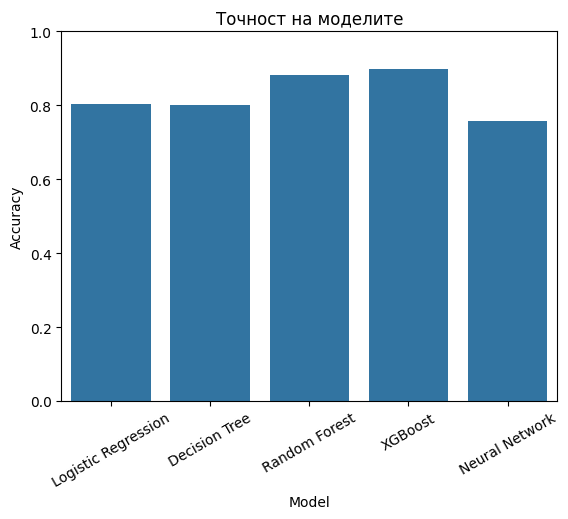

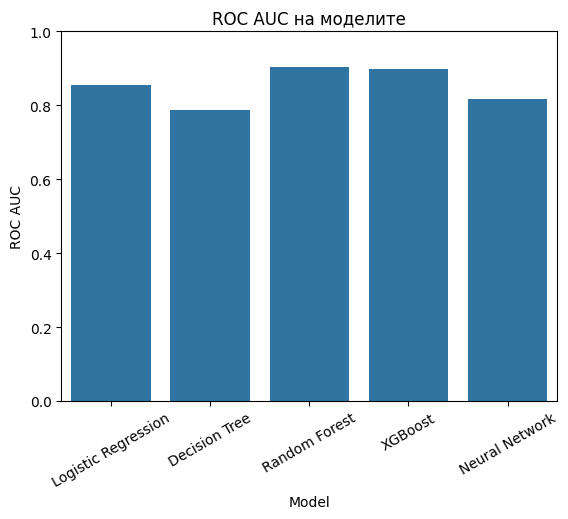

In [17]:
from sklearn.metrics import roc_auc_score

results = {
    "Model": [],
    "Accuracy": [],
    "ROC AUC": []
}

def evaluate_model(name, y_true, y_pred, y_score=None):
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_true, y_pred))
    if y_score is not None:
        results["ROC AUC"].append(roc_auc_score(y_true, y_score))
    else:
        results["ROC AUC"].append(None)

evaluate_model("Logistic Regression", y_test, y_pred_logreg, logreg.predict_proba(X_test)[:,1])
evaluate_model("Decision Tree", y_test, y_pred_dt, dt.predict_proba(X_test)[:,1])
evaluate_model("Random Forest", y_test, y_pred_rf, rf.predict_proba(X_test)[:,1])
evaluate_model("XGBoost", y_test, y_pred_xgb, xgb.predict_proba(X_test)[:,1])
evaluate_model("Neural Network", y_test, (model.predict(X_test) > 0.5).astype(int), model.predict(X_test))

results_df = pd.DataFrame(results)
display(results_df)


sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Точност на моделите")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

sns.barplot(data=results_df, x="Model", y="ROC AUC")
plt.title("ROC AUC на моделите")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


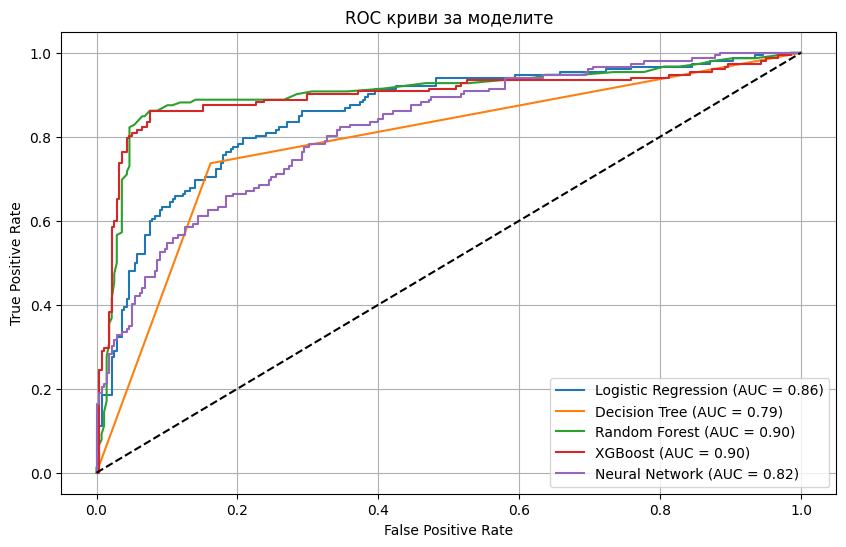

In [18]:

from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

def plot_roc(model_name, y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_true, y_score):.2f})")

plot_roc("Logistic Regression", y_test, logreg.predict_proba(X_test)[:,1])
plot_roc("Decision Tree", y_test, dt.predict_proba(X_test)[:,1])
plot_roc("Random Forest", y_test, rf.predict_proba(X_test)[:,1])
plot_roc("XGBoost", y_test, xgb.predict_proba(X_test)[:,1])
plot_roc("Neural Network", y_test, model.predict(X_test).flatten())

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC криви за моделите")
plt.legend()
plt.grid()
plt.show()


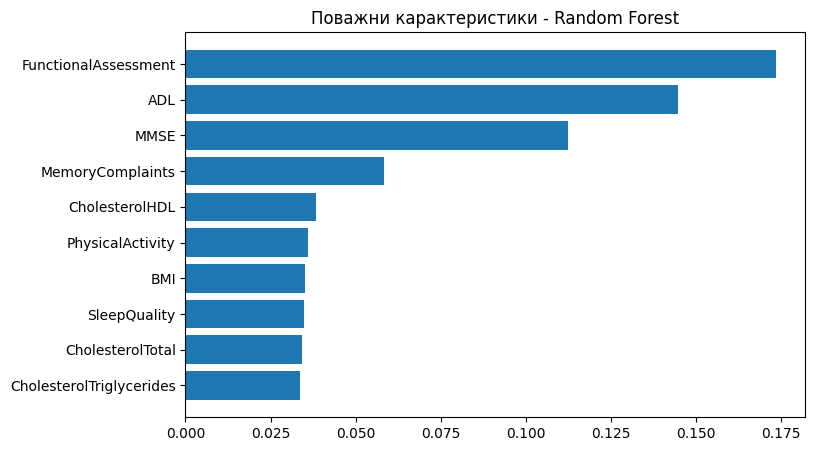

In [19]:

importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.title("Поважни карактеристики - Random Forest")
plt.show()


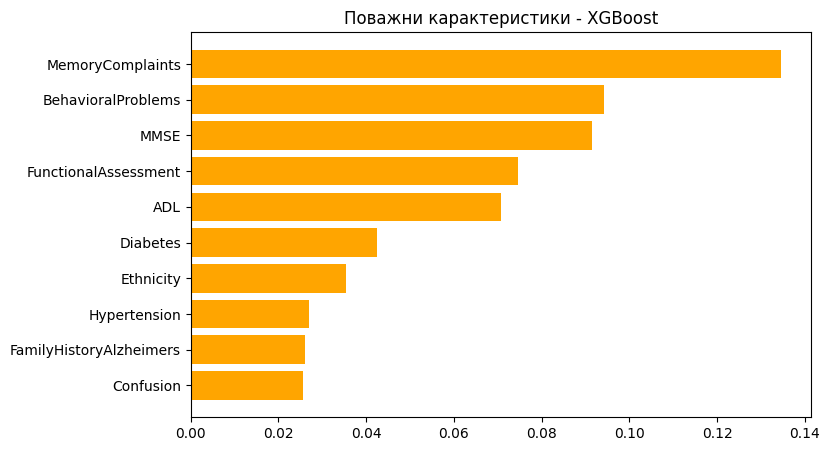

In [20]:

importances_xgb = xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center', color='orange')
plt.yticks(range(len(indices_xgb)), [X.columns[i] for i in indices_xgb])
plt.title("Поважни карактеристики - XGBoost")
plt.show()
